# HiMAP tutorial: human data

This tutorial assumes you've installed HiMAP.

To test, download files from 2 samples of [DIABIMMUNE Tri-county cohort](https://pubs.broadinstitute.org/diabimmune/three-country-cohort/resources/16s-sequence-data):
* [Sample G3225 (forward)](https://pubs.broadinstitute.org/diabimmune/data/10/G63225_R1_001.fastq.gz)
* [Sample G3225 (reverse)](https://pubs.broadinstitute.org/diabimmune/data/10/G63225_R2_001.fastq.gz)
* [Sample G3228 (forward)](https://pubs.broadinstitute.org/diabimmune/data/10/G63228_R1_001.fastq.gz)
* [Sample G3228 (reverse)](https://pubs.broadinstitute.org/diabimmune/data/10/G63228_R2_001.fastq.gz)

and save them to a folder. For the purposes of this tutorial, we will save them to `~/data/diabimmune/fastq_tutorial/`. ~ is a shortcut for an individual user folder.

In these samples, V4 hyper-variable region is sequenced. PCR primers have already been removed from these reads, but we will run the PCR primer removal anyway, to demonstrate the full pipeline.

In [1]:
library(himap)

HiMAP v1.0 loaded.


## Loading files and specifying folders

First, we will need full paths to the FASTQ files for pair-end 16S reads. Filenames for all forwards reads will be stored in `fq_fwd` and reverse in `fq_rev`.

In [2]:
fastq_path = '~/data/diabimmune/tutorial/fastq'
fq_fwd = read_files(fastq_path, 'R1')
fq_rev = read_files(fastq_path, 'R2')

The filenames are used to extract identifiers for each file, either with forward or reverse reads. The function `sampleids_from_filenames` will retrieve those, given a separator (default is the underscore _). For example, from forward files: 

In [3]:
head(fq_fwd)

[1] "/Users/igor/data/diabimmune/tutorial/fastq/G63225_R1_001.fastq.gz"
[2] "/Users/igor/data/diabimmune/tutorial/fastq/G63228_R1_001.fastq.gz"

we would like `G63225` and `G63228` labels:

In [4]:
sample_ids = sampleids_from_filenames(fq_fwd, separator='_')
head(sample_ids)

[1] "G63225" "G63228"

HiMAP will output a number of output files and folders, which will be explained as we go along, so specify a folder where to save all files:

In [5]:
out_path = path.expand('~/data/diabimmune/tutorial')
out_path

[1] "/Users/igor/data/diabimmune/tutorial"

## Merging reads

First specify the output files for each sample, then merge:

In [6]:
fq_mer = file.path(out_path, 'merged', paste0(sample_ids, '.fastq'))
mergestats = merge_pairs(fq_fwd, fq_rev, fq_mer, verbose=T)

Loading FASTQ reads: G63225_R1_001.fastq.gz, G63225_R2_001.fastq.gz ... OK.
Merging pairs... OK.
Writing output files... OK.
Loading FASTQ reads: G63228_R1_001.fastq.gz, G63228_R2_001.fastq.gz ... OK.
Merging pairs... OK.
Writing output files... OK.


Check how many reads are merged and not merged:

In [7]:
mergestats

,/Users/igor/data/diabimmune/tutorial/fastq/G63225_R1_001.fastq.gz,/Users/igor/data/diabimmune/tutorial/fastq/G63228_R1_001.fastq.gz
total,107153,129781
low_pct_sim,1264,989
low_aln_len,6,20


Out of 107,153 total reads, in the first sample 1,264 were not merged due to low percentage similarity in the alignment (if this number is high, consider lowering `min_sim` parameter) and 6 due to overlap alignment being too short (less than default 50 nt). If this number of reads in `low_aln_len` is too high, that overlap alignment was rejected due to being too short, in which case minimum alignment length needs to be reduced (parameter `min_aln_len`). See `?merge_pairs` for more details.

## Remove PCR primers

Remove PCR primers from merged reads. First, we will create output filenames, then remove standard V4 region primers. Exact primer sequences can also be specified using arguments `pr_fwd` and `pr_rev`; see `?remove_pcr_primers` for details.

In [8]:
fq_pcr = file.path(out_path, 'primer_removed', paste0(sample_ids, '.fastq'))
trimstats = remove_pcr_primers(fq_mer, fq_pcr, region='V4')

In [9]:
trimstats

,/Users/igor/data/diabimmune/tutorial/merged/G63225.fastq,/Users/igor/data/diabimmune/tutorial/merged/G63228.fastq
fwd_trim,0,0
rev_trim,1,0


No primers were found in this dataset.

## Quality control and fixed-length trimming

Since the input for DADA2 denoising requires all sequences to be trimmed to the fixed length, we first inspect the distribution of sequence lengths before choosing this parameter:

In [10]:
seqlen.ft = sequence_length_table(fq_pcr)

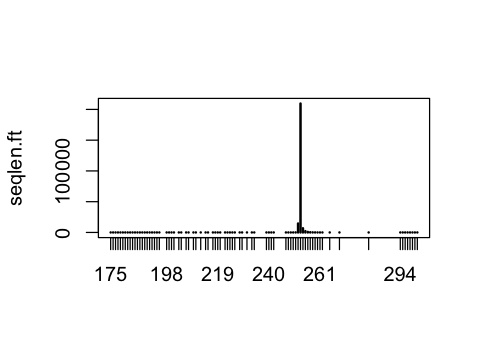

In [11]:
options(repr.plot.width=4, repr.plot.height=3) # Make a small plot
plot(seqlen.ft)

We can select the minimum trimming length by finding the length above which we have 99% of the reads, since most of the reads here have 252 and 253 nt length.

In [12]:
trim_length = ftquantile(seqlen.ft, 0.01)
trim_length

[1] 252

Now we can use that to do the trimming. For quality control keep sequences with 2 or less expected errors [Edgar, Flyberg]. This also removes any phiX sequences and sequences containing any Ns after truncation (trimming):

In [13]:
fq_tri = file.path(out_path, 'filtered', paste0(sample_ids, '.fastq'))
filtstats = filter_and_trim(fq_pcr, fq_tri, truncLen=trim_length, verbose=T)

As before, the function returns the table showing the number of reads kept during the QC filtering process:

In [14]:
filtstats

,reads.in,reads.out
G63225.fastq,105889,98352
G63228.fastq,128782,122382


## Denoising

For denoising, we use `dada` function from the dada2 package. After the denoising part is done, for each partition, we retrieve pre-trimmed (after PCR removal) sequences and add their consensus sequence back. This can improve the accuracy of the alignment to the reference database in one of the next steps.

In [15]:
dada_result = dada_denoise(fq_tri, fq_pcr)

55624968 total bases in 220734 reads from 2 samples will be used for learning the error rates.
Initializing error rates to maximum possible estimate.
selfConsist step 1 ..
   selfConsist step 2
   selfConsist step 3
   selfConsist step 4
   selfConsist step 5
   selfConsist step 6
Convergence after  6  rounds.
Sample 1 - 98352 reads in 33105 unique sequences.
Sample 1 - 122382 reads in 37169 unique sequences.


### Saving/restoring R variables
Ocassionally, R might crash due to various reasons. For very long computations it is a good idea to have checkpoints and save finished computations. R variables can be saved (into compressed files) using `saveRDS` function, and loaded back using `readRDS`. For example, to save the file:

In [16]:
saveRDS(dada_result, '~/data/diabimmune/tutorial/dada_result')

This saved `dada_result` variable to a file '~/data/diabimmune/tutorial/dada_result'. To read it back in the new R session use:

In [17]:
dada_result = readRDS('~/data/diabimmune/tutorial/dada_result')

## Count sequences, remove bimeras, collapse sequences from multiple samples

Next, we count the number of reads for each denoised sequence, remove chimeric (here bimeric) reads. If we work with multiple samples, we pool together denoised sequences that are identical up to shifts or length variation:

In [18]:
ab.dt = sequence_abundance(dada_result)

* generating sequence table...

The sequences being tabled vary in length.


 OK.
* removing bimeras...

Identified 930 bimeras out of 1416 input sequences.


 OK.
* adding together sequences that differ in shifts on lengths...collapse:
* generating temporary files...OK.
* blast word size: 202 
* running blast...blast status:  0
OK.
* selecting ends-free alignments...OK.
* no sequences need collapsing.
* cleaning up temporary files...OK.
* returning input.
 OK.


We can inspect the sequence abundance table:

In [19]:
head(ab.dt, 10)

sample_id,qseqid,raw_count,sequence
G63225,1,25318,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATGTCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCCTGCTAAGCTGCAACTGACATTGAGGCTCGAAAGTGTGGGTATCAAACAGG
G63228,1,31,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATGTCTTGAGTGCAGTTGAGGCAGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCCTGCTAAGCTGCAACTGACATTGAGGCTCGAAAGTGTGGGTATCAAACAGG
G63225,2,0,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTGCGTAGGCTGTTTCGTAAGTCGTGTGTGAAAGGCGCGGGCTCAACCCGCGGACGGCACATGATACTGCGAGACTAGAGTAATGGAGGGGGAACCGGAATTCTCGGTGTAGCAGTGAAATGCGTAGATATCGAGAGGAACACTCGTGGCGAAGGCGGGTTCCTGGACATTAACTGACGCTGAGGCACGAAGGCCAGGGGAGCGAAAGGG
G63228,2,23179,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTGCGTAGGCTGTTTCGTAAGTCGTGTGTGAAAGGCGCGGGCTCAACCCGCGGACGGCACATGATACTGCGAGACTAGAGTAATGGAGGGGGAACCGGAATTCTCGGTGTAGCAGTGAAATGCGTAGATATCGAGAGGAACACTCGTGGCGAAGGCGGGTTCCTGGACATTAACTGACGCTGAGGCACGAAGGCCAGGGGAGCGAAAGGG
G63225,3,825,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGTAGCAAACAGG
G63228,3,9932,AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGGTGTAGCGGTGGAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGGCCTACTGGGCACCAACTGACGCTGAGGCTCGAAAGTGTGGGTAGCAAACAGG
G63225,4,413,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTGCGGCAAGTCTGATGTGAAAGCCCGGGGCTCAACCCCGGTACTGCATTGGAAACTGTCGTACTAGAGTGTCGGAGGGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGATAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGG
G63228,4,8417,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTGCGGCAAGTCTGATGTGAAAGCCCGGGGCTCAACCCCGGTACTGCATTGGAAACTGTCGTACTAGAGTGTCGGAGGGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTACTGGACGATAACTGACGCTGAGGCTCGAAAGCGTGGGGAGCAAACAGG
G63225,5,0,TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGACGCTCAACGTCTGCACTGCAGCGCGAACTGGTTTCCTTGAGTACGCACAAAGTGGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTCACTGGAGCGCAACTGACGCTGAAGCTCGAAAGTGCGGGTATCGAACAGG
G63228,5,7914,TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGCGTGTTGTGAAATGTAGACGCTCAACGTCTGCACTGCAGCGCGAACTGGTTTCCTTGAGTACGCACAAAGTGGGCGGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATCACGAAGAACTCCGATTGCGAAGGCAGCTCACTGGAGCGCAACTGACGCTGAAGCTCGAAAGTGCGGGTATCGAACAGG


where `sample_id` denotes our sample identifiers, `qseqid` are just integers enumerating unique sequences and `raw_count` is the total number of reads in each sample for that sequence.

Generally, large number of unique sequences are identified by bimeras, however they should not make up a large fraction of total counts. Here we have:

In [20]:
ab.dt[, sum(raw_count)]

[1] 195313

reads, and without bimera removal we would have:

In [21]:
ab_with_bimera.dt = sequence_abundance(dada_result, remove_bimeras=F)

* generating sequence table...

The sequences being tabled vary in length.


 OK.
* adding together sequences that differ in shifts on lengths...collapse:
* generating temporary files...OK.
* blast word size: 202 
* running blast...blast status:  0
OK.
* selecting ends-free alignments...OK.
* no sequences need collapsing.
* cleaning up temporary files...OK.
* returning input.
 OK.


In [22]:
ab_with_bimera.dt[, sum(raw_count)]

[1] 220258

So about 11% of the reads are bimeric by abundance, and about 66% (930 out of 1416) of all unique sequences.

## Align sequences vs reference database

Now that we have a final list of sequences, we align these sequences to the reference database. We BLAST these sequences against our V4 region HiMAP database:

In [23]:
blast_output = blast(ab.dt, region='V4', verbose=T)

* blast input type: abundance table
* blast out: OK. blast best: OK. copy number table: OK.
merge: OK. Fix overhang differences:..OK. OK.


## Calculate OSU abundances

We then use sequence abundance table `ab.dt` and `blast_output` to infer OSUs: 

In [24]:
osu_ab.dt = abundance(ab.dt, blast_output)

In [25]:
head(osu_ab.dt, 10)

sample_id,osu_id,osu_count,pctsim,species
G63225,2844,8439,100.00,"Bacteroides_dorei_DSM_17855,Bacteroides_sp._9_1_42FAA,Bacteroides_dorei_5_1_36/D4,Bacteroides_sp._3_1_33FAA,Bacteroides_dorei_An16,Bacteroides_dorei_An41,Bacteroides_dorei_175,Bacteroides_dorei_CL02T00C15,Bacteroides_dorei_CL02T12C06,Bacteroides_dorei_CL03T12C01"
G63225,3274,7165,100.00,"Bacteroides_ovatus_SD_CMC_3f,Bacteroides_ovatus_3725_D9_iii,Bacteroides_ovatus_CL09T03C03,Bacteroides_ovatus_KLE1656,Bacteroides_sp._KFT8"
G63225,1000009,4172,95.26,Ruminococcus_bicirculans_80/3
G63225,2627,3881,100.00,"Burkholderiales_bacterium_1_1_47,Parasutterella_excrementihominis_YIT_11859"
G63225,2791,2128,100.00,"Alistipes_putredinis_DSM_17216,Alistipes_putredinis_JCM_16772"
G63225,2954,2107,100.00,"Dialister_invisus_DSM_15470,Dialister_invisus_E7.25,Dialister_invisus_JCM_17566"
G63225,6799,1976,100.00,Oscillibacter_sp._ER4
G63225,5660,1939,100.00,"Oscillibacter_sp._KLE_1728,Oscillibacter_sp._KLE_1745,Oscillospiraceae_bacterium_VE202-24"
G63225,7746,1743,100.00,"Faecalibacterium_prausnitzii_2789STDY5608869,Faecalibacterium_prausnitzii_CNCM_I_4575"
G63225,1000023,1586,99.60,"Burkholderiales_bacterium_1_1_47,Parasutterella_excrementihominis_YIT_11859"


## Add taxonomy

For each OSU, we get taxonomic ranks for all detected strains. This is done by retrieving classification from the offline version of the NCBI Taxonomy database, included with the HiMAP package.

In [26]:
osu_tax.dt = taxonomy(osu_ab.dt)

In [27]:
head(osu_tax.dt[order(osu_id)], 10)

osu_id,pctsim,phylum,class,order,family,genus
1,100,Actinobacteria_[145],Actinobacteria_[145],Bifidobacteriales_[145],Bifidobacteriaceae_[145],Bifidobacterium_[145]
150,100,Proteobacteria_[8448],Gammaproteobacteria_[8448],Enterobacterales_[8448],Enterobacteriaceae_[8448],"Escherichia_[7472],Shigella_[974],Citrobacter_[1],Klebsiella_[1]"
355,100,Proteobacteria_[1],Gammaproteobacteria_[1],Enterobacterales_[1],Enterobacteriaceae_[1],Escherichia_[1]
532,100,Proteobacteria_[1906],Gammaproteobacteria_[1906],Pseudomonadales_[1906],Pseudomonadaceae_[1906],"Pseudomonas_[1906],Hepatobacter_[1]"
581,100,Firmicutes_[109],Bacilli_[109],Lactobacillales_[109],Streptococcaceae_[109],Lactococcus_[109]
1404,100,Proteobacteria_[1],Gammaproteobacteria_[1],Enterobacterales_[1],Enterobacteriaceae_[1],Klebsiella_[1]
1485,100,Bacteroidetes_[103],Bacteroidia_[103],Bacteroidales_[103],Bacteroidaceae_[103],Bacteroides_[103]
1533,100,Actinobacteria_[26],Actinobacteria_[26],Bifidobacteriales_[26],Bifidobacteriaceae_[26],Bifidobacterium_[26]
1565,100,Bacteroidetes_[20],Bacteroidia_[20],Bacteroidales_[20],Bacteroidaceae_[20],Bacteroides_[20]
1670,100,Firmicutes_[98],Bacilli_[98],Lactobacillales_[98],Streptococcaceae_[98],Streptococcus_[98]


Reference table between OSUs and exact sequences:

In [28]:
osu_seq.dt = osu_sequences(osu_ab.dt, blast_output)
head(osu_seq.dt)

osu_id,species,qseqid,copy_number,pctsim,sequence
1,"Bifidobacterium_longum_[91],Bifidobacterium_breve_[52],Bifidobacterium_sp._12_1_47BFAA,Bifidobacterium_sp._TRE_D",53,2,100,TACGTAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGGGCTCGTAGGCGGTTCGTCGCGTCCGGTGTGAAAGTCCATCGCTTAACGGTGGATCCGCGCCGGGTACGGGCGGGCTTGAGTGCGGTAGGGGAGACTGGAATTCCCGGTGTAACGGTGGAATGTGTAGATATCGGGAAGAACACCAATGGCGAAGGCAGGTCTCTGGGCCGTTACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACAGG
150,"Escherichia_coli_[7451],Shigella_sonnei_[850],Shigella_flexneri_[70],Shigella_boydii_[51],Escherichia_fergusonii_[7],Escherichia_albertii_[2],Shigella_dysenteriae_[2],Citrobacter_braakii_SCC4,Escherichia_marmotae_HT073016,Escherichia_sp._1_1_43,Escherichia_sp._3_2_53FAA,Escherichia_sp._4_1_40B,Escherichia_sp._B1147,Escherichia_sp._KTE11,Escherichia_sp._KTE159,Escherichia_sp._KTE172,Escherichia_sp._KTE52,Escherichia_sp._KTE96,Escherichia_sp._TW09308,Escherichia_vulneris_ATCC_33821,Klebsiella_oxytoca_2880STDY5682666,Shigella_sp._PAMC_28760",121,2,100,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCTGATACTGGCAAGCTTGAGTCTCGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACGAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGG
355,Escherichia_coli_MOD1-EC5273,121,1,100,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCTGATACTGGCAAGCTTGAGTCTCGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACGAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGG
355,Escherichia_coli_MOD1-EC5273,415,1,100,TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGAAGAATAAGTCTGATGTGAAAGCCCTCGGCTTAACCGAGGAACTGCATCGGAAACTGTTTTTCTTGAGTGCAGAAGAGGAGAGTGGAACTCCATGTGTAGCGGTGGAATGCGTAGATATATGGAAGAACACCAGTGGCGAAGGCGGCTCTCTGGTCTGCAACTGACGCTGAGGCTCGAAAGCATGGGTAGCGAACAGG
532,"Pseudomonas_aeruginosa_[1873],Candidatus_Hepatobacter_penaei_NHPB,Pseudomonas_denitrificans_(nomen_rejiciendum),Pseudomonas_otitidis_LNU-E-001,Pseudomonas_sp._2_1_26,Pseudomonas_sp._HMSC057H01,Pseudomonas_sp._HMSC058A10,Pseudomonas_sp._HMSC058B07,Pseudomonas_sp._HMSC058C05,Pseudomonas_sp._HMSC059F05,Pseudomonas_sp._HMSC05H02,Pseudomonas_sp._HMSC060F12,Pseudomonas_sp._HMSC060G01,Pseudomonas_sp._HMSC060G02,Pseudomonas_sp._HMSC061A10,Pseudomonas_sp._HMSC063H08,Pseudomonas_sp._HMSC064G05,Pseudomonas_sp._HMSC065H01,Pseudomonas_sp._HMSC065H02,Pseudomonas_sp._HMSC066A08,Pseudomonas_sp._HMSC066B03,Pseudomonas_sp._HMSC067D05,Pseudomonas_sp._HMSC067F09,Pseudomonas_sp._HMSC067G02,Pseudomonas_sp._HMSC069G05,Pseudomonas_sp._HMSC070B12,Pseudomonas_sp._HMSC071F02,Pseudomonas_sp._HMSC072F09,Pseudomonas_sp._HMSC073F05,Pseudomonas_sp._HMSC075A08,Pseudomonas_sp._HMSC076A11,Pseudomonas_sp._HMSC076A12,Pseudomonas_sp._HMSC16B01,Pseudomonas_sp._P179,Pseudomonas_sp._YS-1p",446,1,100,TACGAAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTCAGCAAGTTGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTACTGAGCTAGAGTACGGTAGAGGGTGGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAGGAACACCAGTGGCGAAGGCGACCACCTGGACTGATACTGACACTGAGGTGCGAAAGCGTGGGGAGCAAACAGG
581,"Lactococcus_lactis_[108],Lactococcus_taiwanensis_0905C15",304,3,100,TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGTGGTTTATTAAGTCTGGTGTAAAAGGCAGTGGCTCAACCATTGTATGCATTGGAAACTGGTAGACTTGAGTGCAGGAGAGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCGGTGGCGAAAGCGGCTCTCTGGCCTGTAACTGACACTGAGGCTCGAAAGCGTGGGGAGCAAACAGG


## Save output

Finally, let's save the outputs:

In [29]:
write_table(osu_ab.dt, file.path(out_path, 'osu_abundances.txt'))
write_table(osu_seq.dt, file.path(out_path, 'osu_sequences.txt'))
write_table(osu_tax.dt, file.path(out_path, 'osu_taxonomy.txt'))